Notebook for Optim application. Notebook for supplementary material of a submitted publication. 

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


%matplotlib widget
import time
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_optim_complex,
)


import gemseo as gm

gm.configure_logger()

<RootLogger root (INFO)>

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [2]:
from aeromaps.utils.functions import create_partitioning

In [3]:
create_partitioning(file="data_optim/aeroscope_europe_data.csv", path="data_optim")

## 2. Run AeroMAPS on this studied scope

In [4]:
%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import default_models_top_down

In [5]:
models = {
    "models_optim_complex": models_optim_complex,
}
models["models_optim_complex"]["default_models_top_down"]["models_traffic"].pop("rpk")
models["models_optim_complex"]["default_models_top_down"]["models_operation_cost_top_down"].pop(
    "passenger_aircraft_total_cost_and_airfare"
)

Create process as usual, the partitionning is recuperated as specified in the config file.

In [6]:
process = create_process(
    configuration_file="data_optim/config.json", models=models, use_fleet_model=False
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [7]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [1.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [1.0]
process.parameters.reference_cagr_aviation_reference_periods = []
process.parameters.reference_cagr_aviation_reference_periods_values = [1.0]

## 1-b) Aircraft fleet

Top-down fleet, without hydrogen aircraft, callibrated on the fleet of the MACC applciation, with drop-in instead of h2  
http://localhost:8888/lab/tree/aeromaps/notebooks/data_cost/top_down_cost_callibration_phd.ipynb

Mean annual efficiency improvement: 1.4% --> applied to all catgeories

In [8]:
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [1.4]

## Hydrogen aircraft
# NONE

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [9]:
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

In [10]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

Top-down callibrated on the values of teh MACC apllication.
Faster optim but caution as MFSP full computation is more detailled: larges use of e-fuel in the begining influence late mFSp (no-decomissioning)

In [11]:
# # Energy settings: production choices

# # Aircraft energy - Introduction of alternative drop-in fuels

# ## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.biofuel_share_reference_years_values = np.array([4.8, 15, 24, 27, 35])
process.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.electrofuel_share_reference_years_values = np.array([1.2, 5, 10, 15, 35])


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]

In [12]:
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years_values = [0.815488]
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years_values = [1.052703]
process.parameters.biofuel_ft_others_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_others_mfsp_simple_reference_years_values = [1.378082]
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years_values = [1.142423]
process.parameters.biofuel_atj_mfsp_simple_reference_years = []
process.parameters.biofuel_atj_mfsp_simple_reference_years_values = [1.38668]

process.parameters.electrofuel_mfsp_simple_reference_years = [
    2020,
    2021,
    2022,
    2023,
    2024,
    2025,
    2026,
    2027,
    2028,
    2029,
    2030,
    2031,
    2032,
    2033,
    2034,
    2035,
    2036,
    2037,
    2038,
    2039,
    2040,
    2041,
    2042,
    2043,
    2044,
    2045,
    2046,
    2047,
    2048,
    2049,
    2050,
]
process.parameters.electrofuel_mfsp_simple_reference_years_values = [
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.573659,
    3.426978,
    3.277308,
    3.130003,
    3.095717,
    3.062247,
    3.029682,
    2.998903,
    2.971869,
    2.946851,
    2.923276,
    2.901135,
    2.882374,
    2.866464,
    2.852876,
    2.841350,
    2.829845,
    2.807006,
    2.774737,
    2.737160,
    2.698305,
    2.660365,
    2.624329,
    2.590476,
]

# Enerdata scenario europe-specific data (https://eneroutlook.enerdata.net/forecast-world-co2-intensity-of-electricity-generation.html)
process.parameters.electricity_emission_factor_reference_years = [
    2020,
    2025,
    2030,
    2035,
    2040,
    2045,
    2050,
]
process.parameters.electricity_emission_factor_reference_years_values = [
    205,
    175,
    92,
    47,
    31,
    19,
    12,
]

# Optimisation parameters
europe_ask_share = 15.49 / 100

process.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share  # --> sensitivity 4.8

process.parameters.biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [
    62.8 * europe_ask_share,
    72.1 * europe_ask_share,
    97.8 * europe_ask_share,
    101.8 * europe_ask_share,
]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456 * europe_ask_share,
    137.5452 * europe_ask_share,
    212.7996 * europe_ask_share,
    276.6168 * europe_ask_share,
]

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2

## 1-e) Other process.parameters 

Downscaling not automatic

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 9.90
process.parameters.aviation_electricity_allocated_share = 5.0

In [15]:
process.parameters.price_elasticity = -0.9

## 2 - Problem definition

### Cas 1 

min cumulative_total_airline_cost_discounted

w.r.t. biofuel_share_reference_years_values, electrofuel_share_reference_years_values, 

s.t. cumulative_co2_emissions, electricity_consumption, biomass_consumption, max(biofuel_share_prospective + electrofuel_share_prospective)



In [16]:
from gemseo.algos.design_space import DesignSpace
from gemseo import generate_n2_plot, create_scenario


design_space = DesignSpace()

# process.parameters.airfare_per_rpk=pd.Series(0.09244362820138416, index=range(2000,2051))

process.setup()


max_airfare = 0.15
min_airfare = 0.08
size_airfare = 6
# airfare_init_optim = np.linspace(min_airfare, max_airfare, num=size_airfare)

design_space = DesignSpace()
design_space.add_variable(
    "airfare_per_rpk",
    size=size_airfare,
    lower_bound=np.full(size_airfare, min_airfare),
    upper_bound=np.full(size_airfare, max_airfare),
    value=0.09244362820138416,
)


# design_space.add_variable("electrofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[0, 1.2, 5, 10, 15, 35])
# design_space.add_variable("biofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[2, 4.8, 15, 24, 27, 35])


design_space.add_variable(
    "electrofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[1.53876061e-02, 6.69531291e-02, 1.84765061e00, 8.85047992e00, 1.57302626e01],
)
design_space.add_variable(
    "biofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[11.02945021, 22.64991278, 45.09265767, 50.79100536, 53.35073021],
)


#                   value=[ 2.95630584, 12.01966251, 24.51769195, 45.09794791, 50.85012186,
# 53.05347661]

objective_name = "cumulative_total_surplus_loss_discounted_obj"


process.gemseo_settings["design_space"] = design_space

process.gemseo_settings["objective_name"] = objective_name

# process.gemseo_settings["scenario_type"]="DOE"
process.gemseo_settings["scenario_type"] = "MDO"

# Create a GEMSEO scenario
process.create_gemseo_scenario()

# Set differention method (only use for gradient based optimizers)
process.scenario.set_differentiation_method("finite_differences")

# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint",
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")

process.scenario.add_constraint("airfare_per_rpk_real_constraint_consistency", constraint_type="eq")


process.scenario.formulation.optimization_problem.objective = (
    process.scenario.formulation.optimization_problem.objective * 1e-12
)

##### Base MDO -> in source for DOE [...]

# Configure the algorithm used
algo_options = {
    "ftol_rel": 0.001,
    "ctol_abs": 0.001,
    "ftol_abs": 0.001,
    "normalize_design_space": True,
    "init_step": 0.8,
}
process.scenario.options = {"algo": "NLOPT_COBYLA", "max_iter": 250, "algo_options": algo_options}

 WARNING - 19:27:45: No coupling in MDA, switching chain_linearize to True.


In [17]:
process.compute()

    INFO - 19:27:45:  
    INFO - 19:27:45: *** Start MDOScenario execution ***
    INFO - 19:27:45: MDOScenario
    INFO - 19:27:45:    Disciplines: MDAChain
    INFO - 19:27:45:    MDO formulation: MDF
    INFO - 19:27:46: Optimization problem:
    INFO - 19:27:46:    minimize 1e-12*cumulative_total_surplus_loss_discounted_obj(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 19:27:46:    with respect to airfare_per_rpk, biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 19:27:46:    subject to constraints:
    INFO - 19:27:46:       aviation_carbon_budget_constraint(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 19:27:46:       blend_completeness_constraint(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 19:27:46:       electricity_trajectory_constraint(airfa

Pre-compute time: 0.02293872833251953 seconds


    INFO - 19:32:06:    100%|██████████| 250/250 [04:20<00:00, 57.56 it/min, obj=0.0685]
 WARNING - 19:32:06: Optimization found no feasible point; the least infeasible point is selected.
    INFO - 19:32:06: Optimization result:
    INFO - 19:32:06:    Optimizer info:
    INFO - 19:32:06:       Status: None
    INFO - 19:32:06:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 19:32:06:       Number of calls to the objective function by the optimizer: 252
    INFO - 19:32:06:    Solution:
 WARNING - 19:32:06:       The solution is not feasible.
    INFO - 19:32:06:       Objective: 0.0670071808502517
    INFO - 19:32:06:       Standardized constraints:
    INFO - 19:32:06:          airfare_per_rpk_real_constraint_consistency = [-0.01259247  0.01276851 -0.00495294 -0.01218081  0.01251302  0.00887236]
    INFO - 19:32:06:          aviation_carbon_budget_constraint = 0.012461304895170975
    INFO - 19:32:06:          biofuel_use_growth_constraint 

Compute time: 260.7793769836426 seconds
Post-compute time: 1.014843225479126 seconds


In [18]:
process.vector_outputs_df["airfare_per_rpk_true"]

1940         NaN
1941         NaN
1942         NaN
1943         NaN
1944         NaN
1945         NaN
1946         NaN
1947         NaN
1948         NaN
1949         NaN
1950         NaN
1951         NaN
1952         NaN
1953         NaN
1954         NaN
1955         NaN
1956         NaN
1957         NaN
1958         NaN
1959         NaN
1960         NaN
1961         NaN
1962         NaN
1963         NaN
1964         NaN
1965         NaN
1966         NaN
1967         NaN
1968         NaN
1969         NaN
1970         NaN
1971         NaN
1972         NaN
1973         NaN
1974         NaN
1975         NaN
1976         NaN
1977         NaN
1978         NaN
1979         NaN
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989         NaN
1990         NaN
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997         NaN
1998         N

In [19]:
process.scenario.get_result().design_variable_names_to_values[
    "biofuel_share_reference_years_values"
]

array([10.8362485 , 22.13779121, 46.06782316, 49.9127215 , 54.44314454])

In [20]:
# magic_rpk.append(process.vector_outputs_df['rpk_no_elasticity'].loc[2050])


# for i in range(10):

#     design_space = DesignSpace()


#     design_space.add_variable("electrofuel_share_reference_years_values",
#                               size=5,
#                               lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
#                               upper_bound=[100,100, 100, 100, 100],
#                               value=process.scenario.get_result().design_variable_names_to_values['electrofuel_share_reference_years_values']
#                              )
#     design_space.add_variable("biofuel_share_reference_years_values",
#                               size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
#                               upper_bound=[100,100, 100, 100, 100],
#                               value=process.scenario.get_result().design_variable_names_to_values['biofuel_share_reference_years_values']
#                              )


#     pre=process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050]
#     process.parameters.airfare_per_rpk.loc[2025:2050]=pre

#     magic_method_view.append(process.vector_outputs_df['airfare_per_rpk_true'].loc[2050])
#     magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])


#     process.setup()
#     process.gemseo_settings["design_space"] = design_space
#     process.gemseo_settings["objective_name"] = objective_name
#     # process.gemseo_settings["scenario_type"]="DOE"
#     process.gemseo_settings["scenario_type"] = "MDO"
#     # Create a GEMSEO scenario
#     process.create_gemseo_scenario()
#     # Set differention method (only use for gradient based optimizers)
#     process.scenario.set_differentiation_method("finite_differences")
#     # Add constraints
#     for constraint in all_constraints:
#         process.scenario.add_constraint(constraint, constraint_type="ineq")
#     process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

#     process.scenario.options = {
#         "algo": "NLOPT_COBYLA",
#         "max_iter": 200,
#         "algo_options": algo_options
#     }

#     process.compute()
#     diff= np.linalg.norm(pre - process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050])
#     print(diff)


# 2- Compute

Run AeroMAPS process

In [21]:
# process.compute()

In [22]:
# process.scenario_doe.get_result().optimization_problems_to_results

 WARNING - 19:32:08: Optimization found no feasible point; the least infeasible point is selected.
 WARNING - 19:32:09: Optimization found no feasible point; the least infeasible point is selected.


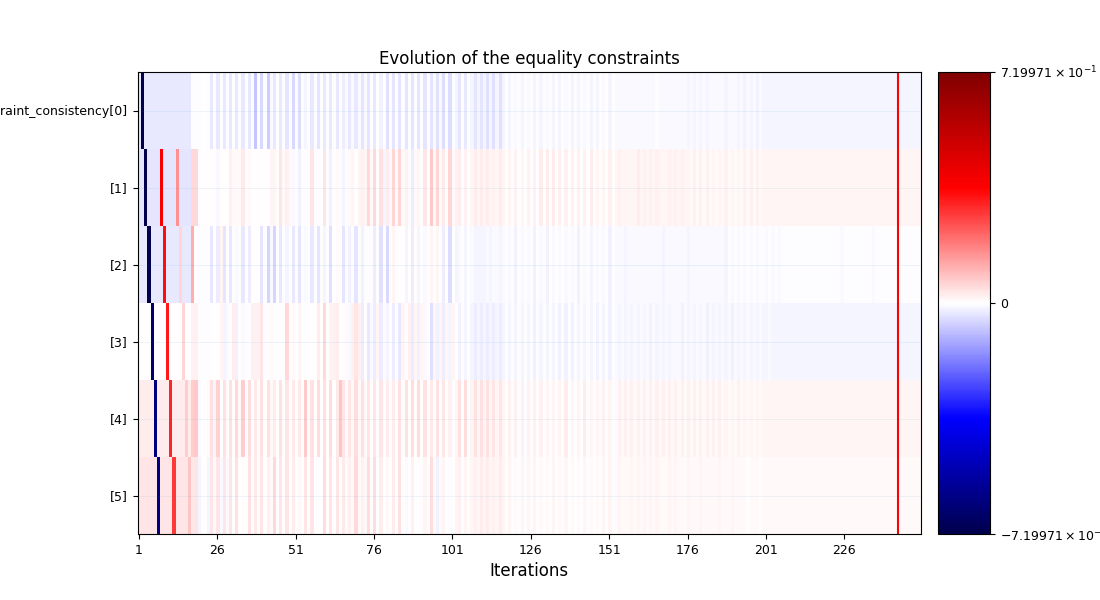

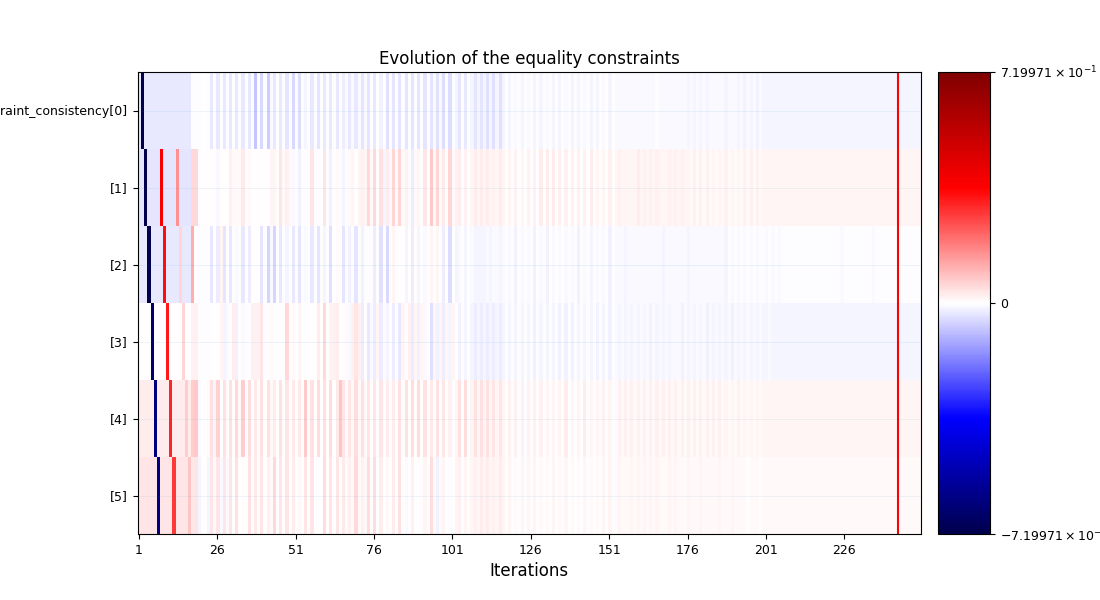

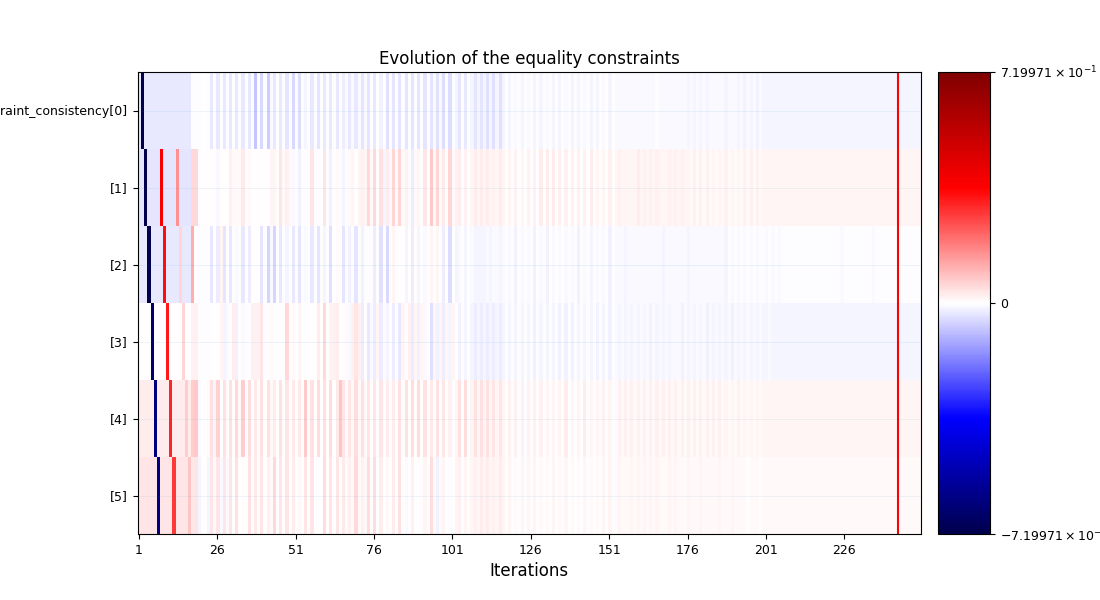

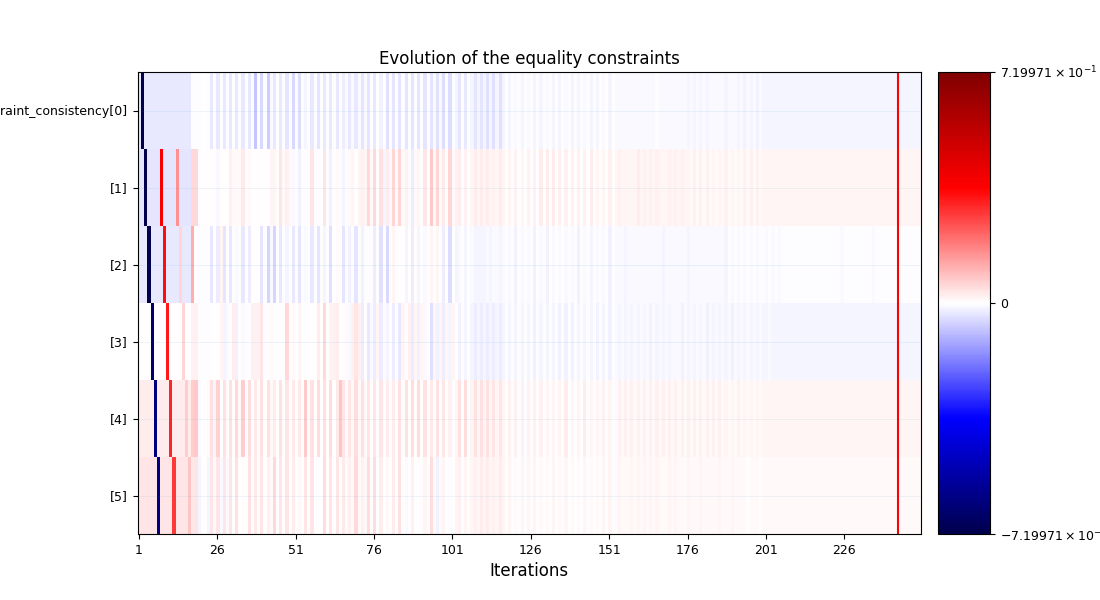

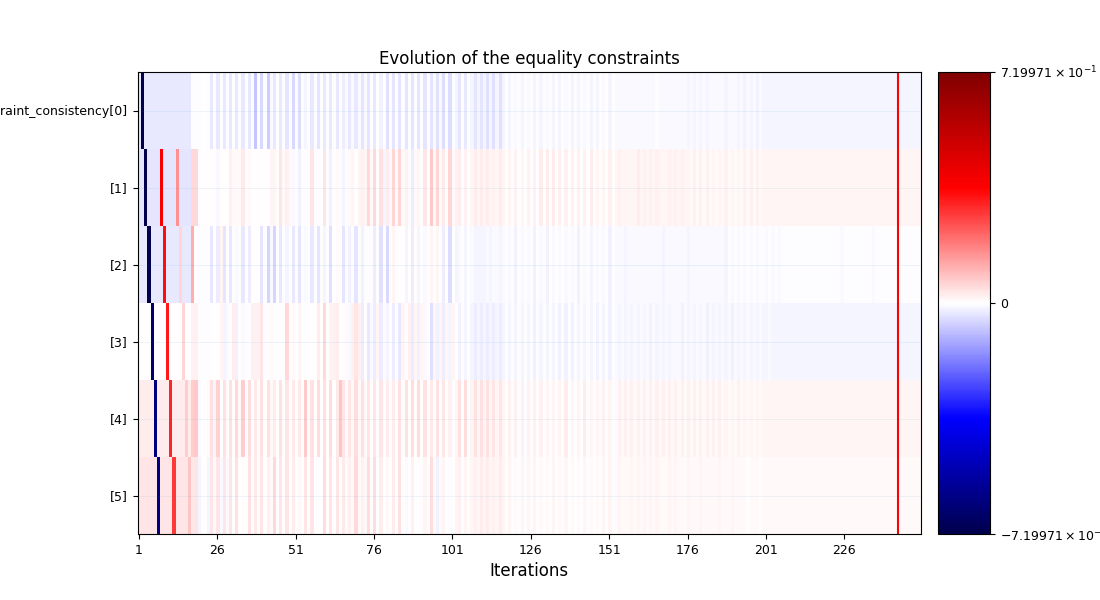

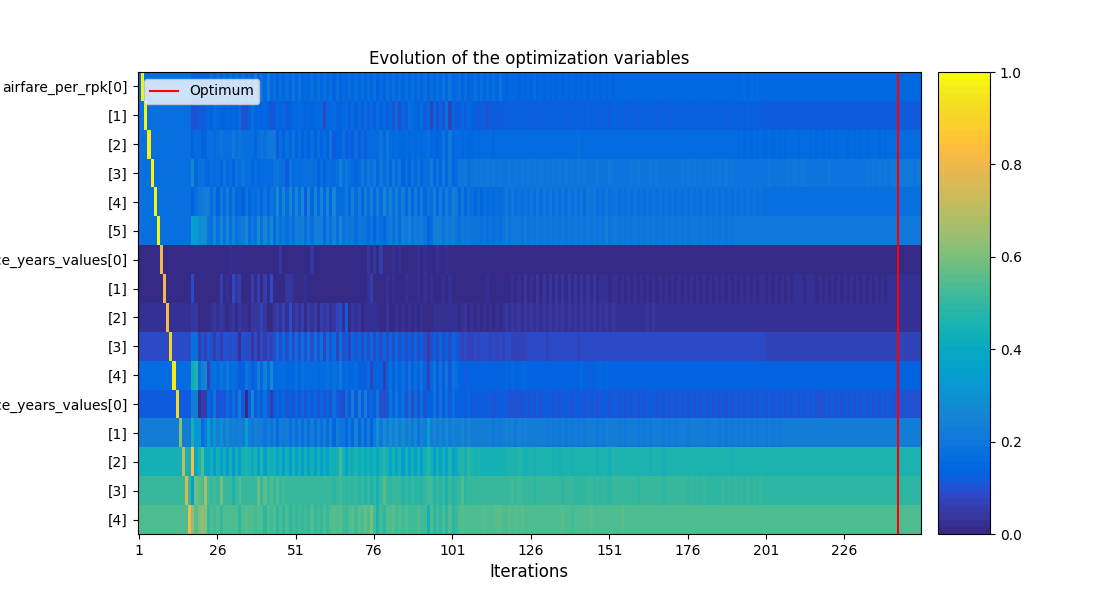

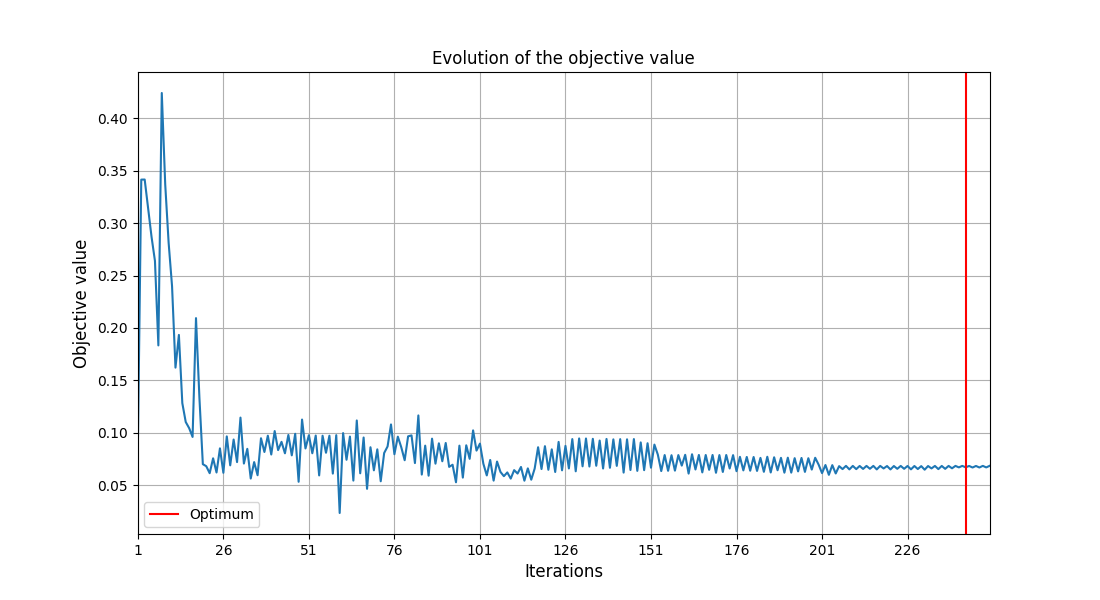

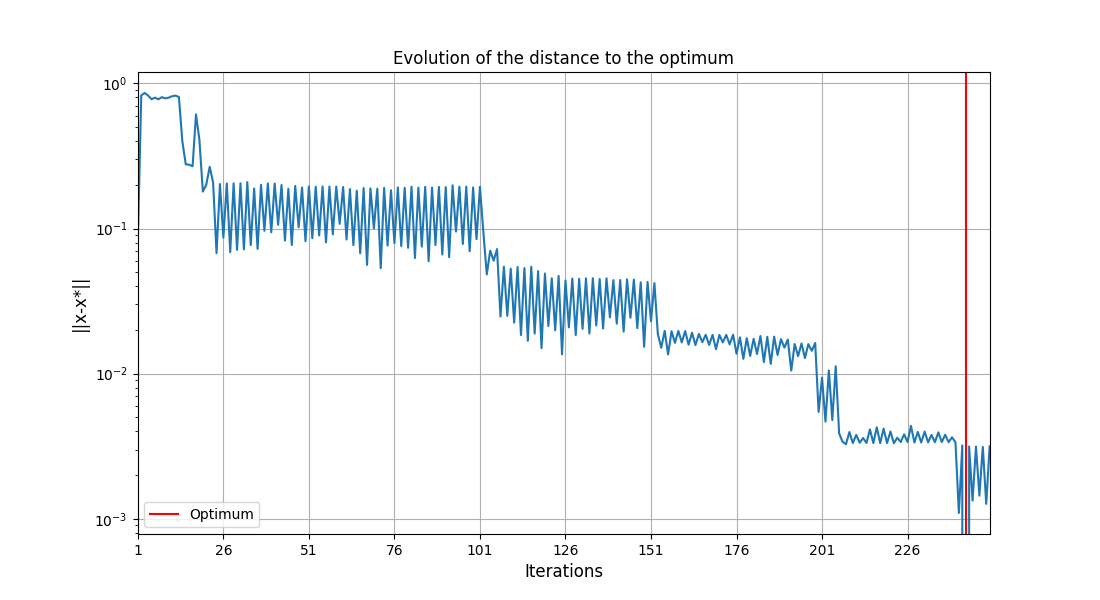

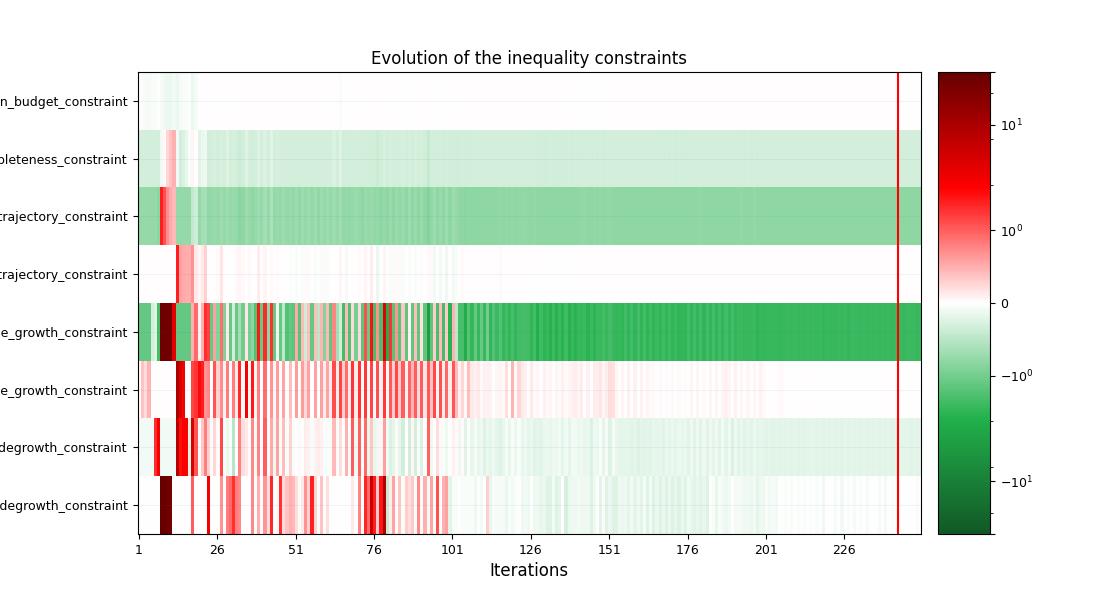

In [23]:
process.scenario.post_process("OptHistoryView", save=False, show=True)

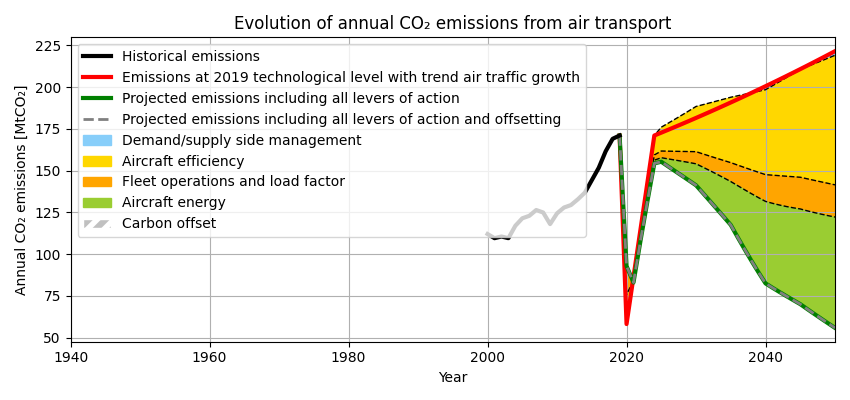

In [24]:
process.plot("air_transport_co2_emissions")

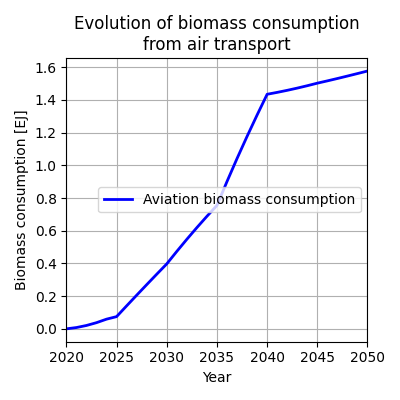

In [25]:
process.plot("biomass_consumption")

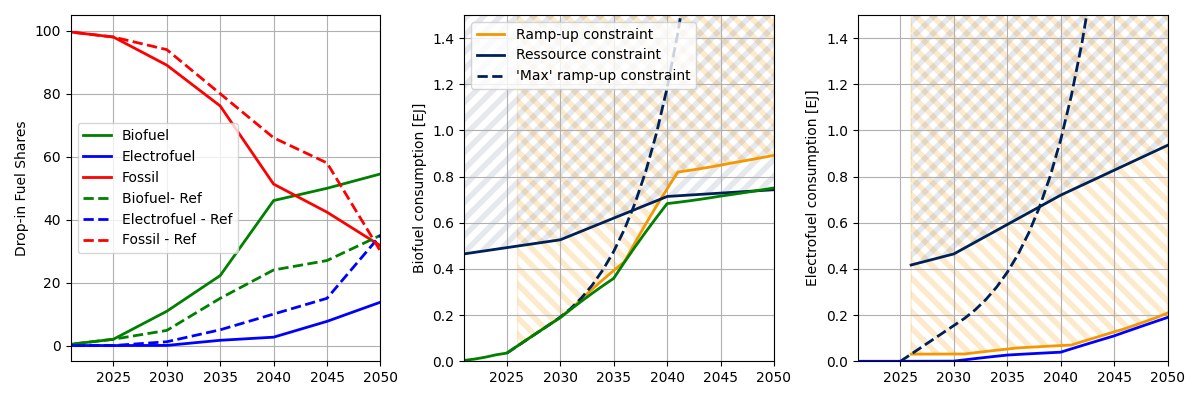

In [26]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)


ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 2, 4.8, 15, 24, 27, 35],
    color="green",
    linestyle="--",
    label="Biofuel- Ref",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 0, 1.2, 5, 10, 15, 35],
    color="blue",
    linestyle="--",
    label="Electrofuel - Ref",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [100, 98, 94.0, 80, 66, 58, 30],
    color="red",
    linestyle="--",
    label="Fossil - Ref",
    linewidth=2,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021, 2050)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    3,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    3,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_growth_constraint_theoretical_max_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_biofuel"
    ]
    / 1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)


ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc="upper left")
ax2.set_xlim(2021, 2050)
ax2.set_ylim(0, 1.5)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    3,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    3,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"],
        "electrofuel_growth_constraint_theoretical_max_viz",
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_electrofuel"
    ]
    / 1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021, 2050)
ax3.set_ylim(0, 1.5)

fig.tight_layout()
fig.savefig("ressource_constraints.png", dpi=800)

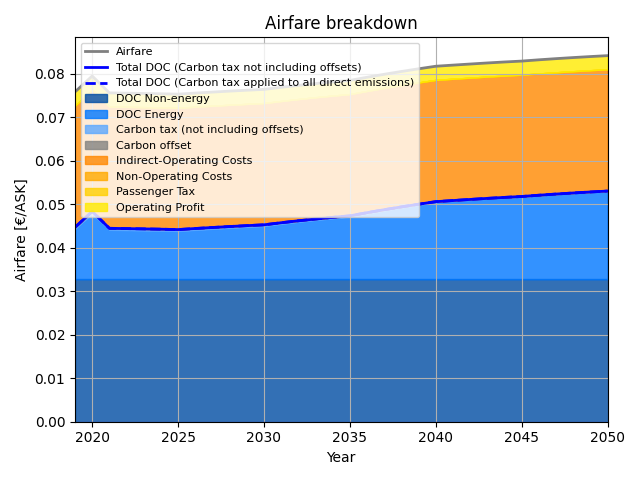

In [27]:
process.plot("airfare_breakdown")

In [28]:
process.vector_outputs_df["cumulative_co2_emissions"][2050]

3.2557395741677864

In [29]:
process.vector_outputs_df["co2_emissions_including_energy"][2050]

55.82977295779904

In [30]:
process.vector_outputs_df["cumulative_total_airline_cost_discounted"][2050]

4620625470129.563

In [31]:
max(process.vector_outputs_df["electricity_consumption"].dropna())

0.4345042526095274

In [32]:
sum(process.vector_outputs_df["electricity_consumption"].dropna())

3.3435331079676622

In [33]:
max(process.vector_outputs_df["biomass_consumption"].dropna())

1.5772431499556927

In [34]:
sum(process.vector_outputs_df["biomass_consumption"].dropna())

25.598070688747363

In [35]:
# from gemseo.algos.design_space import DesignSpace
# from gemseo import generate_n2_plot, create_scenario

# manual_DOE_carbon_budgets = [k * europe_ask_share for k in [2.0, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.2, 3.5, 4.0]]
# manual_DOE_results = {}


# for carbon_budget_share in manual_DOE_carbon_budgets:

#     process.parameters.aviation_carbon_budget_objective = carbon_budget_share

#     process.setup()

#     design_space = DesignSpace()

#     # design_space.add_variable("load_factor_end_year", size=1, lower_bound=89.0, upper_bound=89.5, value=89.2)
#     design_space.add_variable("electrofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 0, 1.2, 5, 10, 15, 35])
#     design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 2, 4.8, 15, 24, 27, 35])
#     # design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=np.array([0, 0, 0,0, 0, 0, 0]), upper_bound=np.array([0, 100, 100,100, 100, 100, 100]), value=np.array([0, 0, 1.2, 5, 10, 15, 35]))
#     # design_space.add_variable("biofuel_share_reference_years_values", size=1, lower_bound=1, upper_bound=100, value=5)

#     objective_name = "cumulative_total_airline_cost_discounted_obj"


#     process.gemseo_settings["design_space"] = design_space

#     process.gemseo_settings["objective_name"] = objective_name

#     # process.gemseo_settings["scenario_type"]="DOE"
#     process.gemseo_settings["scenario_type"] = "MDO"

#     # Create a GEMSEO scenario
#     process.create_gemseo_scenario()

#     # Set differention method (only use for gradient based optimizers)
#     process.scenario.set_differentiation_method("finite_differences")

#     # Add constraints
#     all_constraints = [
#         "aviation_carbon_budget_constraint",
#         "blend_completeness_constraint",
#         "electricity_trajectory_constraint",
#         "biomass_trajectory_constraint",
#         "electrofuel_use_growth_constraint",
#         "biofuel_use_growth_constraint",
#         "biofuel_use_no_degrowth_constraint",
#         "electrofuel_use_no_degrowth_constraint"
#     ]


#     for constraint in all_constraints:
#         process.scenario.add_constraint(constraint, constraint_type="ineq")


#     process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

#     algo_options = {
#         "ftol_rel": 0.001,
#         "ftol_abs": 0.001,
#         "normalize_design_space": True,
#         "init_step":1
#     }
#     # Configure the algorithm used
#     # config_algo = {"algo": "NLOPT_COBYLA", "max_iter": 200}
#     config_algo = {
#         "algo": "NLOPT_COBYLA",
#         "max_iter": 500,
#         "algo_options":algo_options
#     }
#     # config_algo = {"algo": "DIFFERENTIAL_EVOLUTION", "max_iter": 1000}

#     #Configure the DOE used

#     # config_algo = {"algo": "LHS", "n_samples": 1000}


#     process.input_data.update(config_algo)

#     process.compute()

#     manual_DOE_results[carbon_budget_share]=process.scenario.get_result().optimization_problems_to_results



In [36]:
# manual_DOE_results

In [37]:
# {
#   "0.3098": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.0200054873, 2.05140066, 21.1813998, 50.2237717, 62.708779, 67.6659455, 0.0, 6.37460003, 13.3005508, 23.9880299, 34.5420461, 38.6414905, 40.5526613],
#         "Objective function": 4.923723348357994,
#         "Feasible solution": false
#       }
#     }
#   },
#   "0.38725000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 9.50830997e-16, 5.46074505e-15, 4.87835124, 17.8344375, 35.9188935, 44.7192748, 0.0, 6.06082219, 13.16114, 23.2813313, 30.8878381, 35.5180169, 37.1535953],
#         "Objective function": 4.703385363758759,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.40274000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.68528514e-16, 3.52478468e-16, 2.13553207, 11.523514, 27.3651544, 48.9386831, 0.0, 5.57028651, 13.8559199, 14.8875224, 26.9343106, 35.2600772, 37.1299377],
#         "Objective function": 4.65427847765963,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.41823000000000005": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 8.00602614e-15, 0.493206033, 2.15320295, 6.84688915, 16.065036, 35.8409102, 0.0, 5.21639236, 9.54168243, 15.385152, 30.3210818, 35.4914538, 36.6780568],
#         "Objective function": 4.608114408167807,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.43372": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 2.60208521e-15, 2.01227923e-14, 1.90819582e-14, 4.46973153, 14.5540439, 32.7356765, 0.0, 3.12017252, 8.47822827, 13.5795412, 23.1990379, 29.6078295, 34.8518127],
#         "Objective function": 4.569699143108438,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.44921": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.11924028, 0.4731823, 3.9455404, 17.04417396, 40.53708351, 56.24505107, 0.0, 0.08376552, 0.67126784, 8.39397436, 15.21908486, 28.46091729, 36.36557437],
#         "Objective function": 4.659503862073434,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.4647": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.0497717e-16, 1.71911138e-15, 7.20866319e-15, 5.34337113e-14, 2.77555756e-14, 1.61869054, 0.0, 9.96287534e-15, 2.65478792, 10.1524168, 20.8683498, 32.3839377, 37.0775387],
#         "Objective function": 4.4858105558686425,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.49568000000000006": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.209974e-15, 9.07712291e-17, 4.52762243e-17, 0.501961593, 13.5764353, 29.1746387, 0.0, 1.50004538, 10.175401, 20.0427433, 27.2900464, 35.5768404, 37.155043],
#         "Objective function": 4.570591342503452,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.54215": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.6196": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   }
# }
